# Convolutions in Deep Learning

Convolution is one of the fundamental building blocks of deep learning models, especially Convolutional Neural Networks (CNNs). It allows networks to automatically learn spatial features from images.

https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

We will use the Lenna image (a standard benchmark test image) to demonstrate convolution with different kernels.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.io import read_image
import matplotlib.pyplot as plt

The code below to load the Lena image

In [ ]:
!git clone https://github.com/renjiegroup/COMP3065.git images

Cloning into 'images'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 2), reused 13 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 6.37 MiB | 46.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.


torch.Size([1, 3, 512, 512])


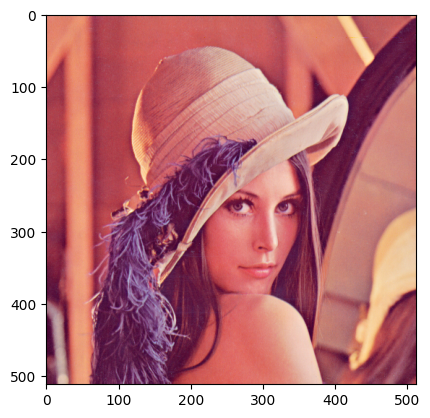

In [ ]:
img = read_image('images/Lenna.png').unsqueeze(0).float() # read the image and increase its dimension
print(img.size())
plt.imshow(img.squeeze(0).data.permute(1,2,0).int().numpy())

## 📝 Demo-1: Image Convolution – Edge Detection & Blurring

### Description

In this exercise, students will apply two different convolution filters to the same image and observe how the results change.

* **Edge Detection** highlights the boundaries in the image, removing most of the texture and color information.
* **Strong Blur (9×9)** smooths the image heavily, removing fine details and producing a soft appearance.

By comparing the outputs side by side with the original image, students will gain an intuitive understanding of how convolution kernels can drastically alter an image.

---

### Key Points / Takeaways

* **Edge Detection**: emphasizes intensity changes, useful for finding shapes and outlines.
* **Blurring (smoothing)**: reduces noise and detail, often used as preprocessing before other tasks.
* **Kernel size matters**: larger kernels (e.g., 9×9) produce stronger blurring effects than smaller ones (e.g., 3×3).
* Small changes in the kernel values can completely change the effect.



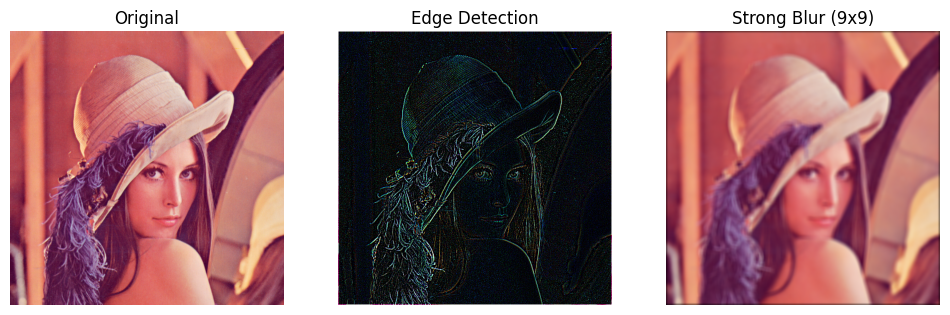

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Kernels
edge_kernel = torch.tensor([[-1., -1., -1.],
                            [-1.,  8., -1.],
                            [-1., -1., -1.]])

blur_kernel = torch.ones((9,9)) / 81.0  # Strong blur

kernels = {
    "Edge Detection": edge_kernel,
    "Strong Blur (9x9)": blur_kernel
}

plt.figure(figsize=(12,4))

# Original
plt.subplot(1, len(kernels)+1, 1)
plt.imshow(img.squeeze(0).permute(1,2,0).int().numpy())
plt.title("Original")
plt.axis("off")

# Apply filters
for i, (name, k) in enumerate(kernels.items(), start=2):
    k = k.unsqueeze(0).unsqueeze(0).repeat(3,1,1,1)
    out = F.conv2d(img, k, padding=k.shape[-1]//2, groups=3)
    plt.subplot(1, len(kernels)+1, i)
    plt.imshow(out.squeeze(0).permute(1,2,0).detach().numpy().clip(0,255).astype("uint8"))
    plt.title(name)
    plt.axis("off")

plt.show()



## Demo-2: The details in Convolution

Convolution is the core operation in Convolutional Neural Networks (CNNs). It transforms an image into a new representation by applying small filters (kernels). Let’s break down the details:

### Convolution without padding

When we perform convolution without padding, we only slide the kernel over regions that are fully inside the original image.
* No extra pixels are added around the border.

* As a result, the kernel cannot cover the edges completely — it has to “fit” inside the image.

* This means the output feature map is smaller than the input.


Patch (0,0):
[[1. 2.]
 [4. 5.]]
Patch × Kernel =
 [[ 1.  0.]
 [ 0. -5.]]
Sum = -4.0


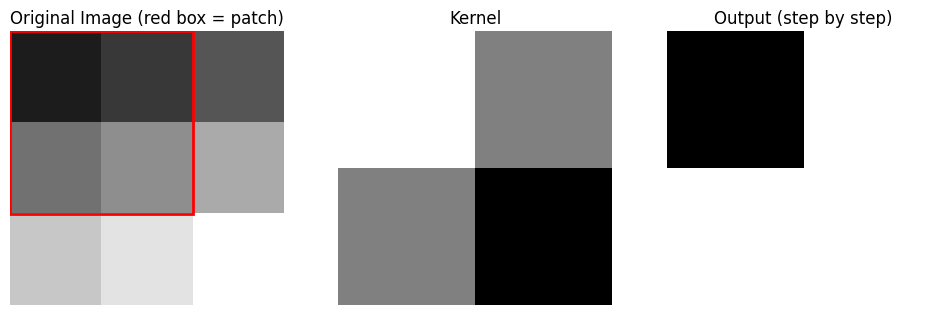


Patch (0,1):
[[2. 3.]
 [5. 6.]]
Patch × Kernel =
 [[ 2.  0.]
 [ 0. -6.]]
Sum = -4.0


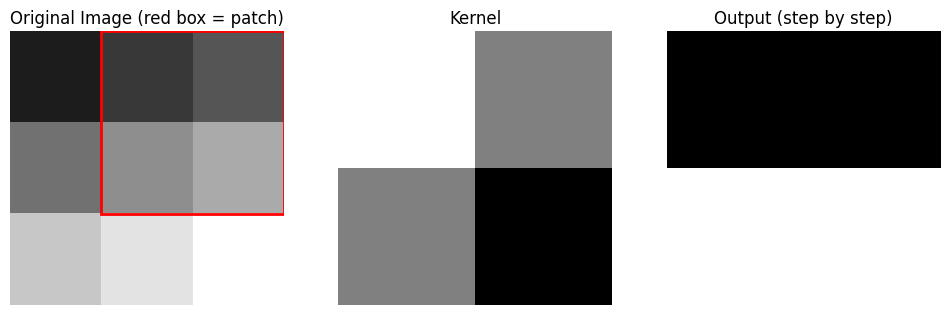


Patch (1,0):
[[4. 5.]
 [7. 8.]]
Patch × Kernel =
 [[ 4.  0.]
 [ 0. -8.]]
Sum = -4.0


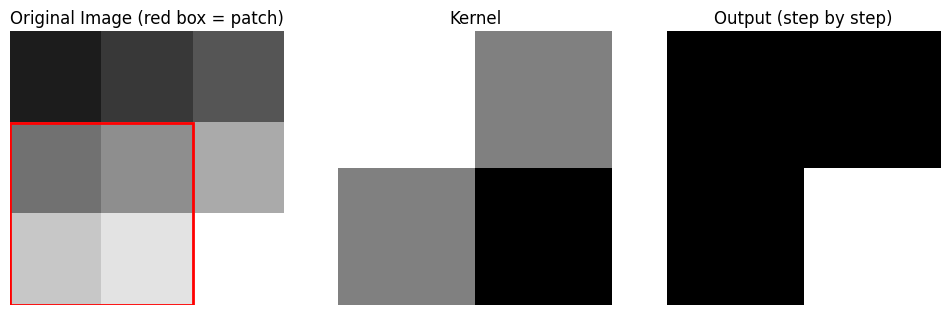


Patch (1,1):
[[5. 6.]
 [8. 9.]]
Patch × Kernel =
 [[ 5.  0.]
 [ 0. -9.]]
Sum = -4.0


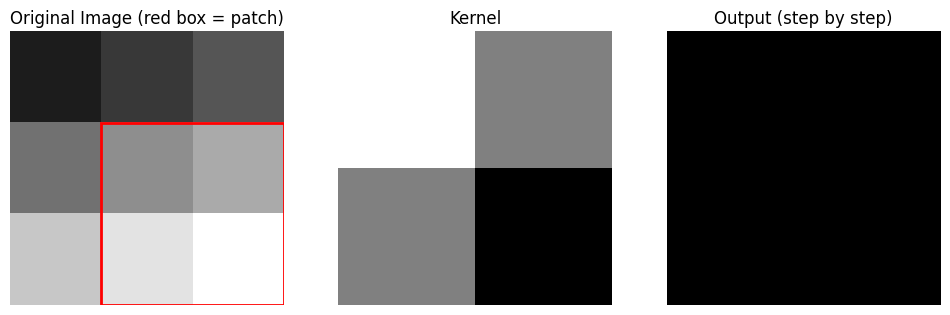

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 🔹 1. Define a simple 3x3 image
image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=np.float32)

# 🔹 2. Define a 2x2 kernel
kernel = np.array([
    [1, 0],
    [0, -1]
], dtype=np.float32)

H, W = image.shape
KH, KW = kernel.shape
out_h, out_w = H - KH + 1, W - KW + 1
output = np.zeros((out_h, out_w))

# 🔹 3. Step-by-step convolution with red box + kernel visualization
for i in range(out_h):
    for j in range(out_w):
        region = image[i:i+KH, j:j+KW]
        product = region * kernel
        value = np.sum(product)
        output[i, j] = value

        print(f"\nPatch ({i},{j}):")
        print(region)
        print("Patch × Kernel =\n", product)
        print("Sum =", value)

        fig, axs = plt.subplots(1, 3, figsize=(12,4))

        # --- Left: Original image with red rectangle around current patch
        axs[0].imshow(image, cmap="gray", vmin=0, vmax=9)
        rect = patches.Rectangle((j-0.5, i-0.5), KW, KH, linewidth=2,
                                 edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)
        axs[0].set_title("Original Image (red box = patch)")
        axs[0].axis("off")

        # --- Middle: Kernel visualization
        axs[1].imshow(kernel, cmap="gray")
        axs[1].set_title("Kernel")
        axs[1].axis("off")

        # --- Right: Convolution output so far
        axs[2].imshow(output, cmap="gray")
        axs[2].set_title("Output (step by step)")
        axs[2].axis("off")

        plt.show()




### Convolution with padding

In convolution with padding, we add extra pixels (usually zeros) around the border of the input image before applying the kernel.

=== Convolution with Padding ===

Patch (0,0):
[[0. 0.]
 [0. 1.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -1.]]
Sum = -1.0


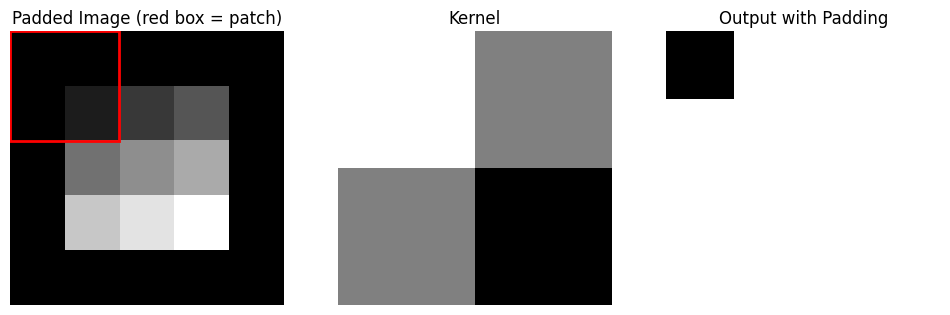


Patch (0,1):
[[0. 0.]
 [1. 2.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -2.]]
Sum = -2.0


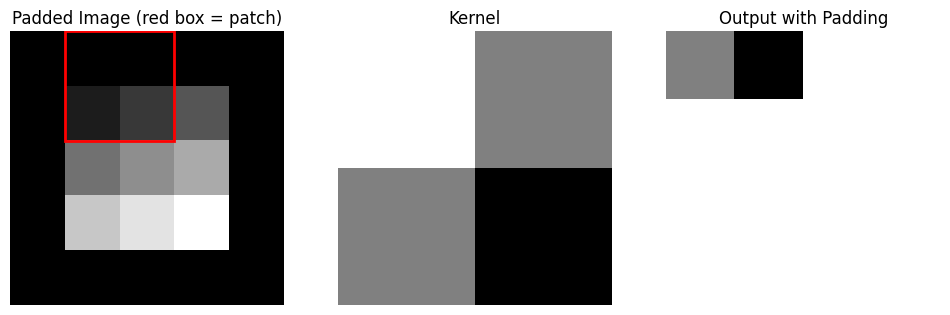


Patch (0,2):
[[0. 0.]
 [2. 3.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -3.]]
Sum = -3.0


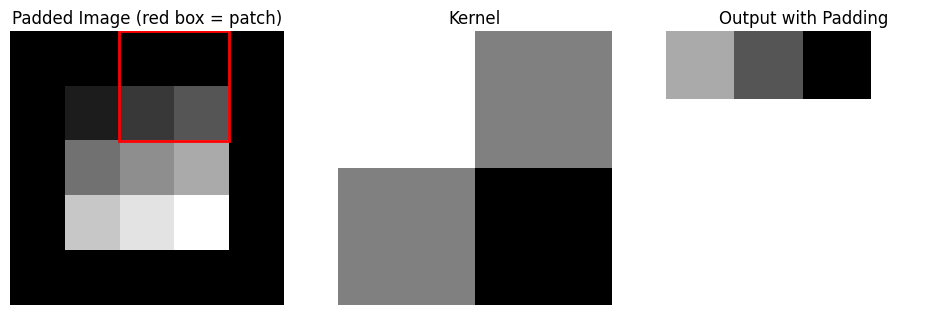


Patch (0,3):
[[0. 0.]
 [3. 0.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -0.]]
Sum = 0.0


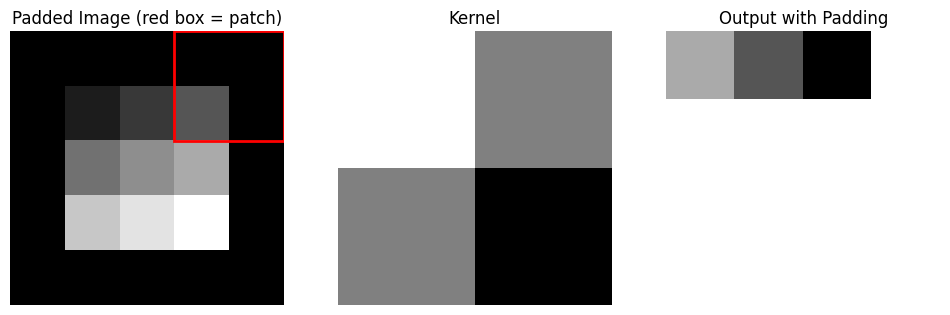


Patch (1,0):
[[0. 1.]
 [0. 4.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -4.]]
Sum = -4.0


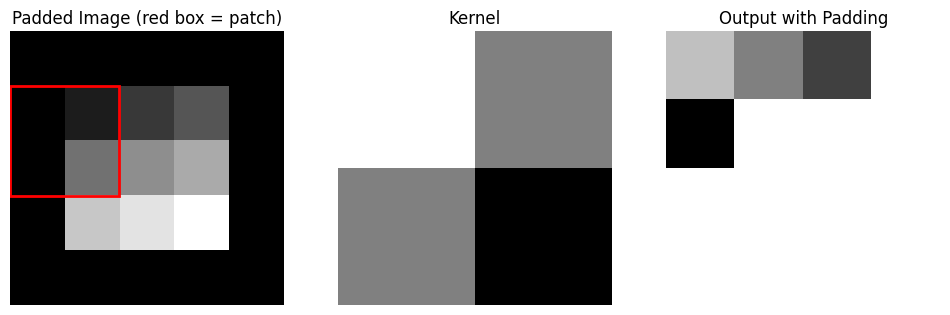


Patch (1,1):
[[1. 2.]
 [4. 5.]]
Patch × Kernel =
 [[ 1.  0.]
 [ 0. -5.]]
Sum = -4.0


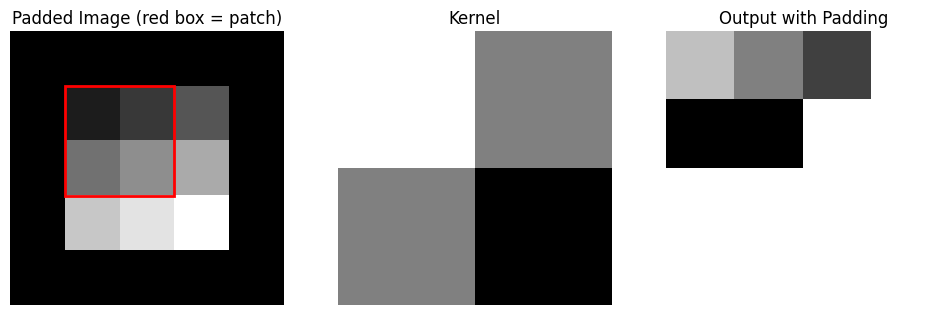


Patch (1,2):
[[2. 3.]
 [5. 6.]]
Patch × Kernel =
 [[ 2.  0.]
 [ 0. -6.]]
Sum = -4.0


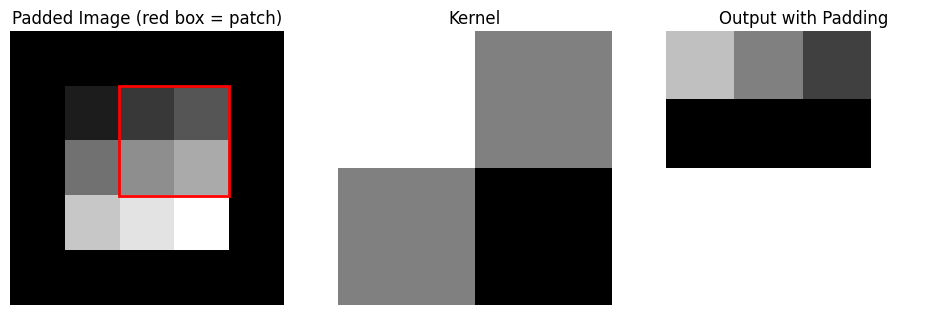


Patch (1,3):
[[3. 0.]
 [6. 0.]]
Patch × Kernel =
 [[ 3.  0.]
 [ 0. -0.]]
Sum = 3.0


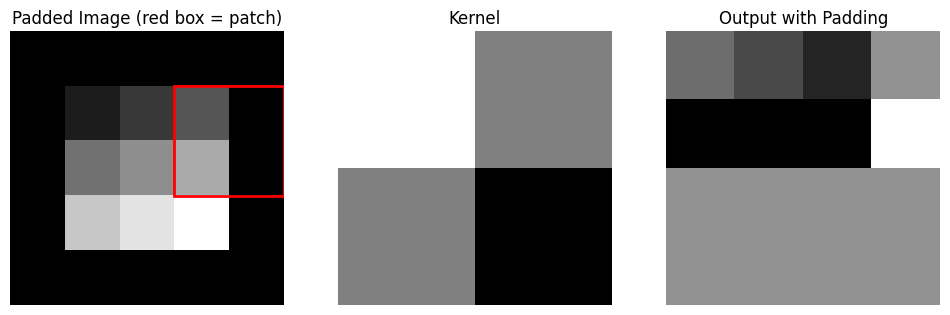


Patch (2,0):
[[0. 4.]
 [0. 7.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -7.]]
Sum = -7.0


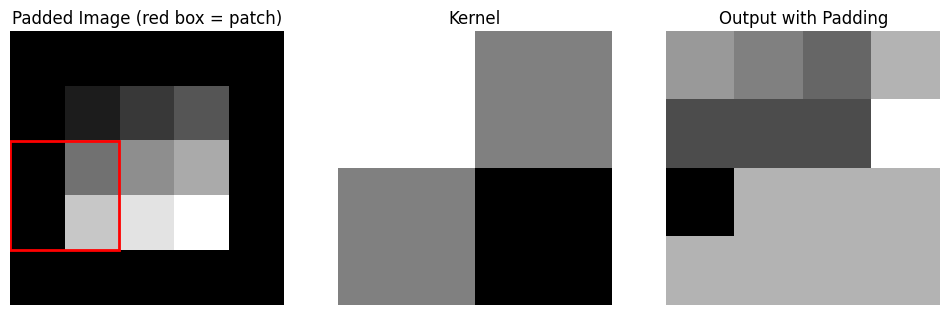


Patch (2,1):
[[4. 5.]
 [7. 8.]]
Patch × Kernel =
 [[ 4.  0.]
 [ 0. -8.]]
Sum = -4.0


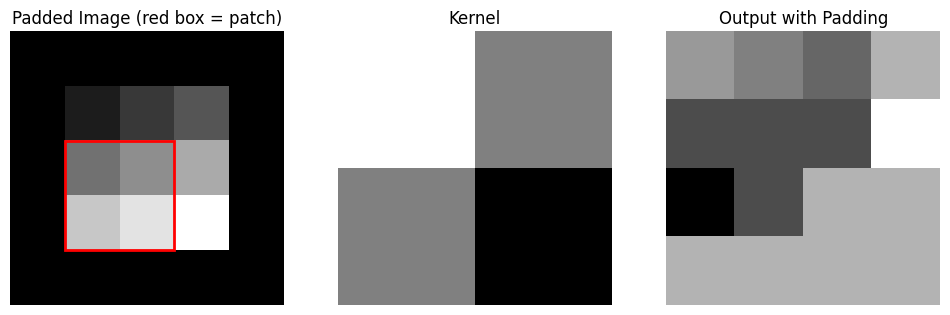


Patch (2,2):
[[5. 6.]
 [8. 9.]]
Patch × Kernel =
 [[ 5.  0.]
 [ 0. -9.]]
Sum = -4.0


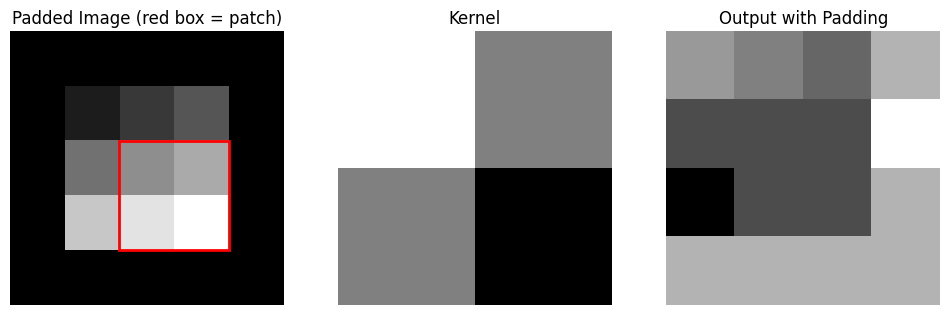


Patch (2,3):
[[6. 0.]
 [9. 0.]]
Patch × Kernel =
 [[ 6.  0.]
 [ 0. -0.]]
Sum = 6.0


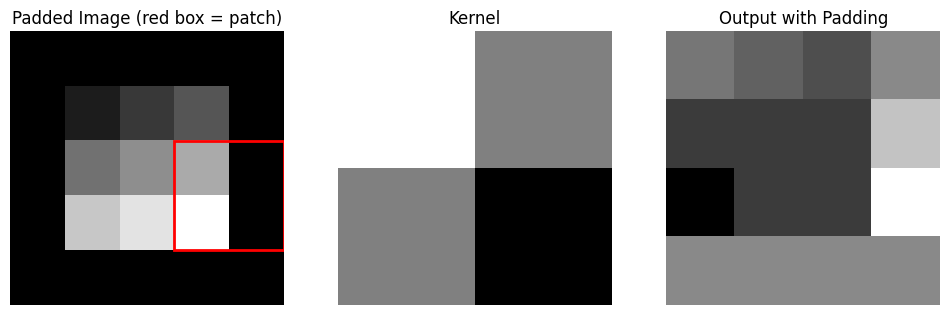


Patch (3,0):
[[0. 7.]
 [0. 0.]]
Patch × Kernel =
 [[ 0.  0.]
 [ 0. -0.]]
Sum = 0.0


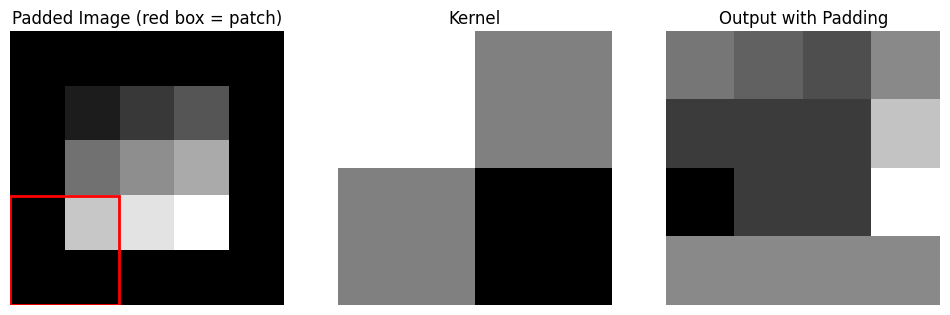


Patch (3,1):
[[7. 8.]
 [0. 0.]]
Patch × Kernel =
 [[ 7.  0.]
 [ 0. -0.]]
Sum = 7.0


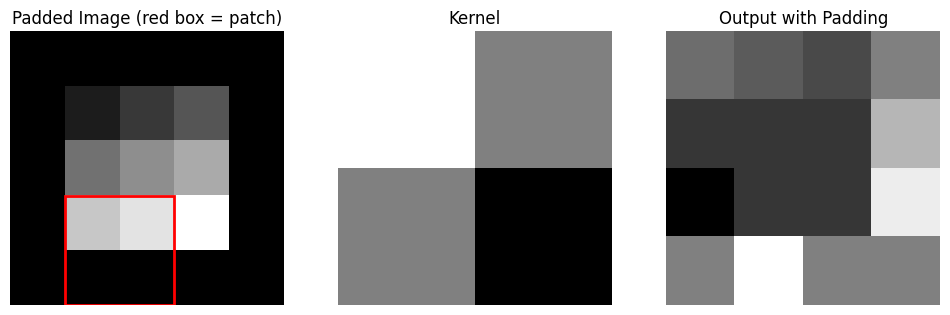


Patch (3,2):
[[8. 9.]
 [0. 0.]]
Patch × Kernel =
 [[ 8.  0.]
 [ 0. -0.]]
Sum = 8.0


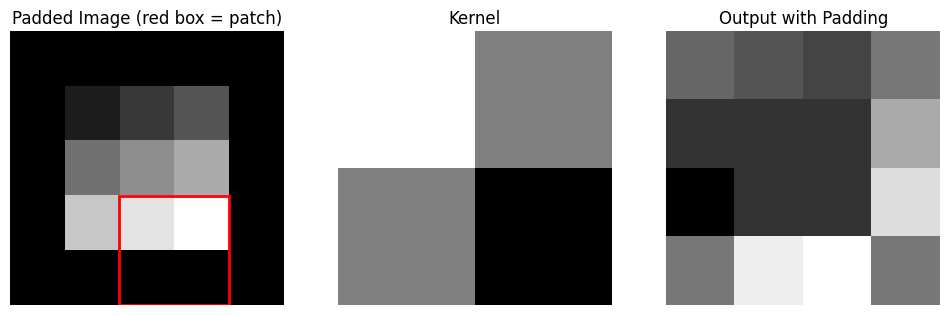


Patch (3,3):
[[9. 0.]
 [0. 0.]]
Patch × Kernel =
 [[ 9.  0.]
 [ 0. -0.]]
Sum = 9.0


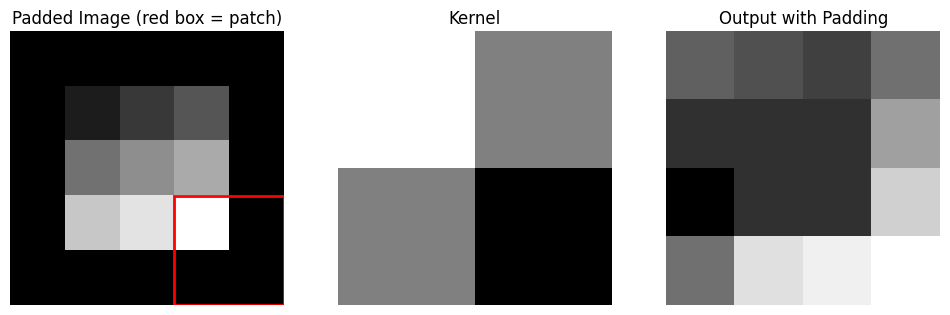


Final Output with Padding:
[[-1. -2. -3.  0.]
 [-4. -4. -4.  3.]
 [-7. -4. -4.  6.]
 [ 0.  7.  8.  9.]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 🔹 1. Define the 3x3 image
image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=np.float32)

# 🔹 2. Define a 2x2 kernel
kernel = np.array([
    [1, 0],
    [0, -1]
], dtype=np.float32)

# 🔹 3. Add zero-padding around the image (1 pixel on each side)
pad = 1
padded = np.pad(image, pad, mode="constant", constant_values=0)

H, W = padded.shape
KH, KW = kernel.shape
out_h, out_w = H - KH + 1, W - KW + 1
output = np.zeros((out_h, out_w))

print("=== Convolution with Padding ===")

for i in range(out_h):
    for j in range(out_w):
        region = padded[i:i+KH, j:j+KW]
        product = region * kernel
        value = np.sum(product)
        output[i, j] = value

        print(f"\nPatch ({i},{j}):")
        print(region)
        print("Patch × Kernel =\n", product)
        print("Sum =", value)

        fig, axs = plt.subplots(1, 3, figsize=(12,4))

        # --- Left: Padded image with red rectangle around current patch
        axs[0].imshow(padded, cmap="gray", vmin=0, vmax=9)
        rect = patches.Rectangle((j-0.5, i-0.5), KW, KH, linewidth=2,
                                 edgecolor='red', facecolor='none')
        axs[0].add_patch(rect)
        axs[0].set_title("Padded Image (red box = patch)")
        axs[0].axis("off")

        # --- Middle: Kernel visualization
        axs[1].imshow(kernel, cmap="gray")
        axs[1].set_title("Kernel")
        axs[1].axis("off")

        # --- Right: Convolution output so far
        axs[2].imshow(output, cmap="gray")
        axs[2].set_title("Output with Padding")
        axs[2].axis("off")

        plt.show()

print("\nFinal Output with Padding:")
print(output)


## Demo-3: Convolution operator in Pytorch
Let's kick off this chapter by using convolution operator from the `torch.nn` package. You are going to create a random tensor which will represent your image and random filters to convolve the image with. Then you'll apply those images.


A **convolution operator** applies a sliding filter (kernel) across an image to extract features.

**`class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`**

- **in_channels**: number of input channels (e.g., 1 for grayscale, 3 for RGB).
- **out_channels**: number of filters to apply → produces multiple feature maps.
- **kernel_size**: size of the sliding window (e.g., 3×3, 5×5).
- **stride**: step size of the sliding window.
- **padding**: adds border pixels so output size can be preserved.

In [ ]:
# Build convolutional filters
conv_filters = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=3, padding=0)
print(img.size())
# Convolve the image with the filters
output_feature = conv_filters(img)

print(output_feature.size())
plt.imshow(output_feature[0].data.permute(1,2,0).numpy().astype(np.uint8))

🔎 **Explanation**: This code demonstrates the convolution operation. A convolutional layer slides a small window (kernel) across the input image, computing weighted sums to extract local features. Benefits of convolution include:
- 📐 Preserves spatial structure
- 🔥 Reduces the number of parameters
- 👀 Captures local patterns such as edges and textures


## Using Multiple Convolution Filters 🧩

🔎 **Explanation**: In practice, convolutional layers often apply **multiple filters** at the same time. Each filter learns to detect a different feature (e.g., horizontal edges, vertical edges, textures, or even more abstract patterns). The outputs from these filters are stacked together to form a richer feature map representation.

- 📊 Multiple filters = multiple channels in the output feature map.
- 🎨 Think of each filter as a 'feature detector' that focuses on a specific aspect of the input.
- 🚀 Combining filters allows the network to capture both low-level (edges, corners) and high-level (shapes, objects) patterns.


In [ ]:

filters = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
filters2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)

print(img.size())
# Convolve the image with the filters
output_feature = filters2(filters(img))

print(output_feature.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 6, 508, 508])


## Check kernel weights of the convolutional layer
You can easily check the kernel of the convolutional layer via ``.weight``

In [ ]:
weight = conv_filters.weight
print(weight.size())

🔎 **Explanation**: This code demonstrates the convolution operation. A convolutional layer slides a small window (kernel) across the input image, computing weighted sums to extract local features. Benefits of convolution include:
- 📐 Preserves spatial structure
- 🔥 Reduces the number of parameters
- 👀 Captures local patterns such as edges and textures


## Maxpooling
Here you are going to practice using max-pooling in both OOP and functional way, and see for yourself that the produced results are the same.
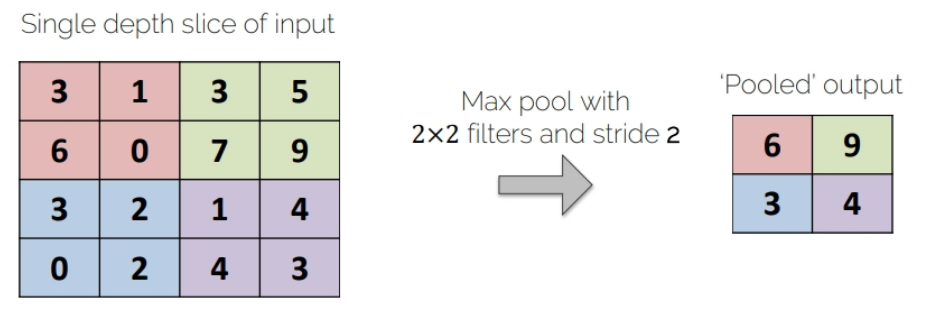

``CLASS torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)``
*  **kernel_size** – the size of the window to take a max over
*  **stride (Union[int, tuple[int, int]])** – the stride of the window. Default value is kernel_size
*  **padding (Union[int, tuple[int, int]])** – Implicit negative infinity padding to be added on both sides

In [ ]:
# Build a pooling operator with size 2
max_pooling = nn.MaxPool2d(3)

# Apply the pooling operator
output_feature = max_pooling(img)

print(output_feature.size())
plt.imshow(output_feature[0].data.permute(1,2,0).int().numpy())


🌊 **Explanation**: This code demonstrates pooling. Pooling layers reduce the size of feature maps, providing **translation invariance** and lowering computational cost. Common types are Max Pooling and Average Pooling.


## Average-pooling operator
After coding the max-pooling operator, you are now going to code the average-pooling operator. You just need to replace max-pooling with average pooling.

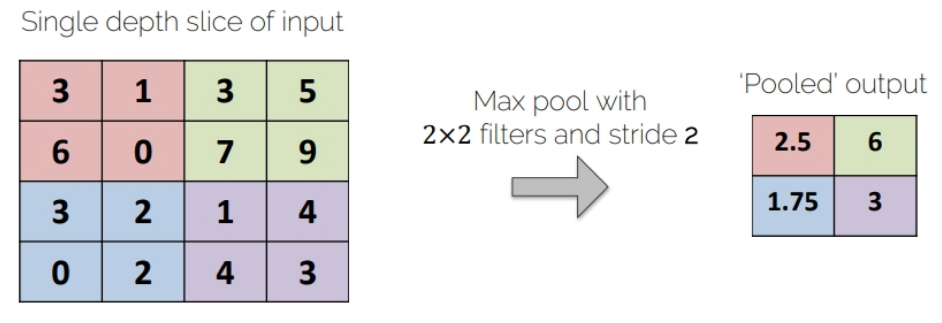

``torch.nn.AvgPool2d(kernel_size, stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None)``
* **kernel_size** – the size of the window

In [ ]:
# Build a pooling operator with size 2
avg_pooling = nn.AvgPool2d(2)

# Apply the pooling operator
output_feature = avg_pooling(img)

plt.imshow(output_feature[0].data.permute(1,2,0).int().numpy())

# Print the results of both cases
print(output_feature.size())


🌊 **Explanation**: This code demonstrates pooling. Pooling layers reduce the size of feature maps, providing **translation invariance** and lowering computational cost. Common types are Max Pooling and Average Pooling.


## Convolution in `nn.Module`

When building neural networks in PyTorch, we usually define them by subclassing `nn.Module`.
This approach makes it easy to organize multiple layers and manage parameters automatically.

**Key points**:

* nn.Conv2d is used to define convolution layers inside the __init__ method.

* You can stack multiple convolution layers (e.g., conv1, conv2, …).

* The forward method describes how data flows through these layers.

* All parameters (weights, biases) of the convolution layers are automatically registered inside the module, so PyTorch knows how to update them during training.

**Why do this instead of calling `nn.Conv2d` directly?**

* ✔️ Cleaner code organization.

* ✔️ Easier to build deep models with many layers.

* ✔️ Compatible with optimizers (torch.optim automatically finds the parameters).

* ✔️ Encourages a modular design — you can reuse your nn.Module as a building block in larger networks.

In [ ]:
import torch
import torch.nn as nn

# A simple CNN with two convolution layers (no activation)
class MultiConvNet(nn.Module):
    def __init__(self):
        super(MultiConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)   # First convolution
        x = self.conv2(x)   # Second convolution
        return x

# Example usage
model = MultiConvNet()
print(model)